In [1]:
import os
from glob import glob
from xorca.lib import load_xorca_dataset
import xgcm
from matplotlib import pyplot as plt
import numpy as np
from cmocean import cm
from matplotlib import colors
import cartopy.crs as ccrs
os.environ['CARTOPY_USER_BACKGROUNDS'] = '/home/shkifmjr/cartopy_images/'
import xesmf as xe
import xarray as xr

import warnings
warnings.simplefilter('ignore')

In [2]:
in_path = '/scratch/usr/shkifmjr/test_plotting/'
mesh_base = [in_path + 'mesh_mask_SURFACE.nc']
mesh_nest = [in_path + '1_mesh_mask_SURFACE.nc']
img = plt.imread('/home/shkifmjr/cartopy_images/BlueMarble_TOPO_010_FEB.png')

In [3]:
data_base = load_xorca_dataset(data_files=sorted(glob(in_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01'
                                                      + '_5d_20050101_20051231_grid_?_SURFACE.nc')),
                               aux_files=mesh_base,
                               model_config='GLOBAL',
                               input_ds_chunks={"time_counter": 1, "t": 1, "z": 1, "deptht": 1, "depthu": 1, "depthv": 1, "depthw": 1},
                               target_ds_chunks = {"t": 1, "z_c": 1, "z_l": 1})

FileNotFoundError: [Errno 2] No such file or directory: b'/scratch/usr/shkifmjr/test_plotting/mesh_mask_SURFACE.nc'

In [10]:
data_nest = load_xorca_dataset(data_files=sorted(glob(in_path + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01'
                                                      + '_5d_20050101_20051231_grid_?_SURFACE.nc')),
                               aux_files=mesh_nest,
                               model_config='NEST',
                               input_ds_chunks={"time_counter": 1, "t": 1, "z": 1, "deptht": 1, "depthu": 1, "depthv": 1, "depthw": 1},
                               target_ds_chunks = {"t": 1, "z_c": 1, "z_l": 1})

In [13]:
# define metrics for xgcm
at_base, au_base = data_base['e1t'] * data_base['e2t'], data_base['e1u'] * data_base['e2u']
av_base, af_base = data_base['e1v'] * data_base['e2v'], data_base['e1f'] * data_base['e2f']

data_base = data_base.update({'at': at_base, 'au': au_base, 'av': av_base, 'af': af_base})
data_base = data_base.set_coords(['at', 'au', 'av', 'af'])

at_nest, au_nest = data_nest['e1t'] * data_nest['e2t'], data_nest['e1u'] * data_nest['e2u']
av_nest, af_nest = data_nest['e1v'] * data_nest['e2v'], data_nest['e1f'] * data_nest['e2f']

data_nest = data_nest.update({'at': at_nest, 'au': au_nest, 'av': av_nest, 'af': af_nest})
data_nest = data_nest.set_coords(['at', 'au', 'av', 'af'])

metrics = {('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
           ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
           ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
           ('X', 'Y'): ['at', 'au', 'av', 'af']} # Areas

In [15]:
grid_base = xgcm.Grid(data_base, metrics=metrics)
grid_nest = xgcm.Grid(data_nest, metrics=metrics)

In [16]:
U_base = grid_base.interp(data_base.vozocrtx, "X", to="center")
V_base = grid_base.interp(data_base.vomecrty, "Y", to="center")
U_nest = grid_nest.interp(data_nest.vozocrtx, "X", to="center")
V_nest = grid_nest.interp(data_nest.vomecrty, "Y", to="center")

In [18]:
speed_base = (U_base ** 2 + V_base ** 2) ** 0.5
speed_nest = (U_nest ** 2 + V_nest ** 2) ** 0.5

In [66]:
data_base = data_base.update({'vospeed': speed_base})
data_nest = data_nest.update({'vospeed': speed_nest})

In [67]:
speed_base_snap = data_base['vospeed'].sel(t=slice('2005-11-16', '2005-11-20')).compute()
speed_nest_snap = data_nest['vospeed'].sel(t=slice('2005-11-16', '2005-11-20')).compute()

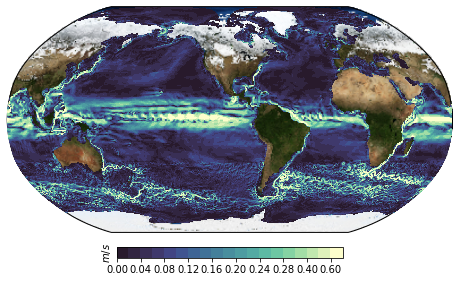

In [69]:
plt.figure(figsize=(8,4))
ax = plt.gca()
    
levs = np.hstack((np.arange(0, 0.3, 0.02), np.arange(0.3, 0.8, 0.1)))
norm = colors.BoundaryNorm(boundaries=levs, ncolors=256)
    
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100.0))

ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='bilinear', regrid_shape=200) # low resolution background
#ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='spline36', regrid_shape=2000) # high resolution background

# need to exclude upper 10 grid cells because of mapping problems
map1 = ax.pcolormesh(data_base.llon_cc.isel(y_c=slice(1,-10)), data_base.llat_cc.isel(y_c=slice(1,-10)),
                    speed_base_snap.where(speed_base_snap > 0).squeeze().isel(y_c=slice(1,-10)), 
                    cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=3)

map2 = ax.pcolormesh(data_nest.llon_cc, data_nest.llat_cc,
                    speed_nest_snap.where(speed_nest_snap > 0).squeeze(), 
                    cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=4)
    
c = plt.colorbar(map1, pad=0.05, shrink=0.4, orientation='horizontal')
c.ax.set_ylabel('$m/s$')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)


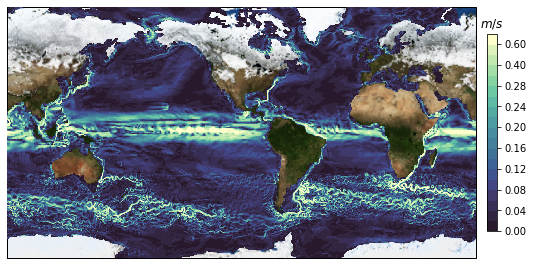

In [55]:
plt.figure(figsize=(8,4))
ax = plt.gca()
    
levs = np.hstack((np.arange(0, 0.3, 0.02), np.arange(0.3, 0.8, 0.1)))
norm = colors.BoundaryNorm(boundaries=levs, ncolors=256)
    
ax = plt.axes(projection=ccrs.Miller(central_longitude=-100.0))
ax.set_extent([-180, 180, -76, 76], ccrs.PlateCarree())

ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='bilinear', regrid_shape=200) # low resolution background
#ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='spline36', regrid_shape=2000) # high resolution background

# need to exclude upper 10 grid cells because of mapping problems
map1 = ax.pcolormesh(data_base.llon_cc.isel(y_c=slice(1,-10)), data_base.llat_cc.isel(y_c=slice(1,-10)),
                    speed_base_snap.where(speed_base_snap > 0).squeeze().isel(y_c=slice(1,-10)), 
                    cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=3)

map2 = ax.pcolormesh(data_nest.llon_cc, data_nest.llat_cc,
                    speed_nest_snap.where(speed_nest_snap > 0).squeeze(), 
                    cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=4)
    
c = plt.colorbar(map1, pad=0.02, shrink=0.7)
c.ax.set_title('$m/s$')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

### interpolate fields first, to avoid problems with plotting high latitudes

In [112]:
lon = np.arange(np.around(data_base['llon_cc'].min().values), np.around(data_base['llon_cc'].max().values), 0.5)
lat = np.arange(np.around(data_base['llat_cc'].min().values), np.around(data_base['llat_cc'].max().values), 0.5)
XI, YI = np.meshgrid(lon, lat)
rect_grid = xr.Dataset({'lat': (['y', 'x'], YI),
                        'lon': (['y', 'x'], XI), })
speed_base_int = xr.Dataset({'time': ('time', speed_base_snap['t']),
                             'z': ('z', speed_base_snap['z_c']),
                             'lat': ('lat', lat),
                             'lon': ('lon', lon), })
speed_base_int = speed_base_int.set_coords(['time', 'lat', 'lon'])
var_to_int = speed_base_snap.rename({'llon_cc': 'lon', 'llat_cc': 'lat'})
regridder = xe.Regridder(var_to_int, rect_grid, 'bilinear', reuse_weights=True)
var_int = regridder(var_to_int)
speed_base_int = speed_base_int.update({'vospeed': (['time', 'z', 'lat', 'lon'], var_int)})

Reuse existing file: bilinear_509x720_334x720.nc


In [106]:
lon = np.arange(np.around(data_nest['llon_cc'][0,0].values), np.around(data_nest['llon_cc'][0,-1].values + 360), 0.1)
lat = np.arange(np.around(data_nest['llat_cc'].min().values), np.around(data_nest['llat_cc'].max().values), 0.1)
XI, YI = np.meshgrid(lon, lat)
rect_grid = xr.Dataset({'lat': (['y', 'x'], YI),
                        'lon': (['y', 'x'], XI), })
speed_nest_int = xr.Dataset({'time': ('time', speed_nest_snap['t']),
                             'z': ('z', speed_nest_snap['z_c']),
                             'lat': ('lat', lat),
                             'lon': ('lon', lon), })
speed_nest_int = speed_nest_int.set_coords(['time', 'lat', 'lon'])
var_to_int = speed_nest_snap.rename({'llon_cc': 'lon', 'llat_cc': 'lat'})
lon_mod = data_nest['llon_cc'].where(data_nest['llon_cc'] > np.around(data_nest['llon_cc'][0,0].values), other=data_nest['llon_cc'] + 360)
var_to_int['lon'].values = lon_mod.values
regridder = xe.Regridder(var_to_int, rect_grid, 'bilinear', reuse_weights=True)
var_int = regridder(var_to_int)
speed_nest_int = speed_nest_int.update({'vospeed': (['time', 'z', 'lat', 'lon'], var_int)})
speed_nest_int['lon'].values = speed_nest_int['lon'].where(speed_nest_int['lon'] < 180., other=speed_nest_int['lon'] - 360).values

Reuse existing file: bilinear_629x3564_380x3570.nc


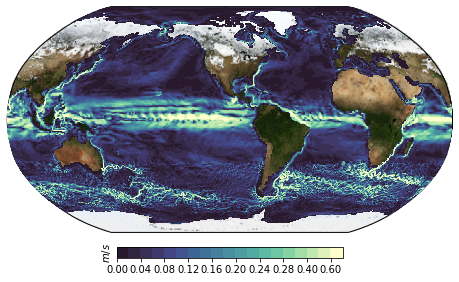

In [116]:
plt.figure(figsize=(8,4))
ax = plt.gca()
    
levs = np.hstack((np.arange(0, 0.3, 0.02), np.arange(0.3, 0.8, 0.1)))
norm = colors.BoundaryNorm(boundaries=levs, ncolors=256)
    
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100.0))

ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='bilinear', regrid_shape=200) # low resolution background
#ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='spline36', regrid_shape=2000) # high resolution background

map1 = ax.pcolormesh(speed_base_int['lon'], speed_base_int['lat'],
                     speed_base_int['vospeed'].where(speed_base_int['vospeed'] > 0).squeeze(), 
                     cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=3)

map2 = ax.pcolormesh(speed_nest_int['lon'], speed_nest_int['lat'],
                     speed_nest_int['vospeed'].where(speed_nest_int['vospeed'] > 0).squeeze(), 
                     cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=4)
    
c = plt.colorbar(map1, pad=0.05, shrink=0.4, orientation='horizontal')
c.ax.set_ylabel('$m/s$')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

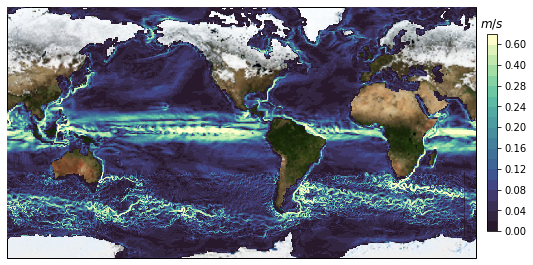

In [117]:
plt.figure(figsize=(8,4))
ax = plt.gca()
    
levs = np.hstack((np.arange(0, 0.3, 0.02), np.arange(0.3, 0.8, 0.1)))
norm = colors.BoundaryNorm(boundaries=levs, ncolors=256)
    
ax = plt.axes(projection=ccrs.Miller(central_longitude=-100.0))
ax.set_extent([-180, 180, -76, 76], ccrs.PlateCarree())

ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='bilinear', regrid_shape=200) # low resolution background
#ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='spline36', regrid_shape=2000) # high resolution background

map1 = ax.pcolormesh(speed_base_int['lon'], speed_base_int['lat'],
                    speed_base_int['vospeed'].where(speed_base_int['vospeed'] > 0).squeeze(), 
                    cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=3)

map2 = ax.pcolormesh(speed_nest_int['lon'], speed_nest_int['lat'],
                     speed_nest_int['vospeed'].where(speed_nest_int['vospeed'] > 0).squeeze(), 
                     cmap=cm.deep_r, norm=norm, transform=ccrs.PlateCarree(), zorder=4)
    
c = plt.colorbar(map1, pad=0.02, shrink=0.7)
c.ax.set_title('$m/s$')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)